In [1]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
os.chdir('../src')

from models.diffusion import Diffusion, CondDiffusion
from models.unet import Unet
from models.condunet import condUnet

reverse_transform = transforms.Compose([transforms.Lambda(lambda x: (x+1)/2), transforms.ToPILImage()])


/home/tsaidi/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = '../outputs/models/cond_fashion_mnist_diffusion_linear_sched_epoch_19.pt'

# model params
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_shape = (28, 28)
channels = 1
dim_mults = (1, 2, 4, )
T = 300

net = condUnet(
    dim=data_shape[0],
    channels=channels,
    dim_mults=dim_mults,
    num_classes=10,
)
net.load_state_dict(torch.load(model_path))

fashion_mnist_cond_diffusion = CondDiffusion(
    model=net,
    data_shape=data_shape,
    noise_schedule='linear',
    T=T,
    device=device,
)

In [4]:
### Adversarial attacks via single gradient step ###
os.makedirs('../outputs/adversary', exist_ok=True)
y_0 = torch.tensor([0], device='cuda:0')
y_1 = torch.tensor([9], device='cuda:0')
deterministic=False

noises = fashion_mnist_cond_diffusion.explicit_sample(y_0, deterministic=deterministic)
adversarial_target = fashion_mnist_cond_diffusion.sample(y_1).squeeze(0)

# # # plot original image
# plt.figure()
# plt.imshow(reverse_transform(noises[-1].squeeze(0).cpu()), cmap='gray')

# # # plot the adversarial target
# plt.figure()
# plt.imshow(reverse_transform(adversarial_target.cpu()), cmap='gray')


In [ ]:
t = 250
latent_noise = noises[fashion_mnist_cond_diffusion.T - t]

loss = torch.norm(noises[-1] - adversarial_target)
grad = torch.autograd.grad(loss, latent_noise)[0]

eps = 1e-2

for j in range(5):
    perturbed_latent = latent_noise - j * eps * grad
    x_t = perturbed_latent
    for i in reversed(range(0, t)):
        t_cur = torch.tensor([i], device='cuda:0')
        x_t = fashion_mnist_cond_diffusion.sample_p_t_grad(x_t, t_cur, y_0, deterministic=deterministic)
    image = reverse_transform(x_t.squeeze(0).cpu())
    plt.imshow(image, cmap='gray')
    # plt.savefig(f'../outputs/adversary/decoded_adversarial_perturbation_t_{t}_eps_{j * eps}.png')

/tmp/ipykernel_295351/1012050820.py:21: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if noise.grad is not None:


loss 23.855018615722656
loss 21.05582618713379
loss 18.003297805786133
loss 13.859009742736816
loss 11.572081565856934
loss 8.31281566619873
loss 5.146822929382324
loss 4.198530197143555
loss 3.2509982585906982
loss 3.606971502304077
loss 3.750135898590088
loss 3.157404899597168
loss 3.626833200454712
loss 4.561069011688232
loss 3.6978399753570557
loss 23.855018615722656
loss 21.79652976989746
loss 18.744953155517578
loss 14.981063842773438
loss 12.375785827636719
loss 9.239593505859375
loss 7.7328314781188965
loss 7.418628692626953
loss 7.301025867462158
loss 5.93538761138916
loss 6.36139440536499
loss 5.704630374908447
loss 5.025547027587891
loss 6.2921013832092285
loss 6.947896957397461
loss 23.855018615722656
loss 20.585914611816406
loss 19.21065902709961
loss 16.945701599121094
loss 16.353824615478516
loss 13.656261444091797
loss 12.910168647766113
loss 10.477665901184082
loss 17.803735733032227
loss 16.1490535736084
loss 14.798966407775879
loss 13.7162446975708
loss 13.9972629547

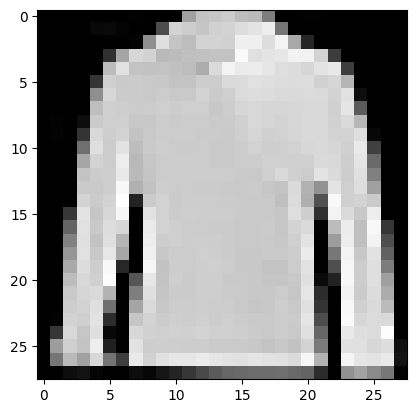

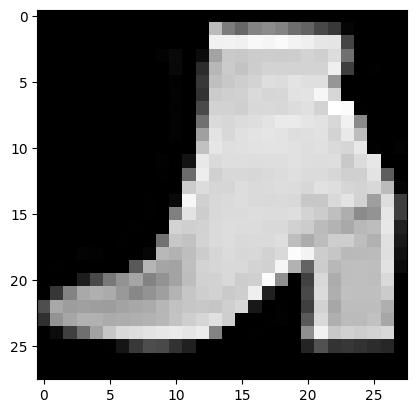

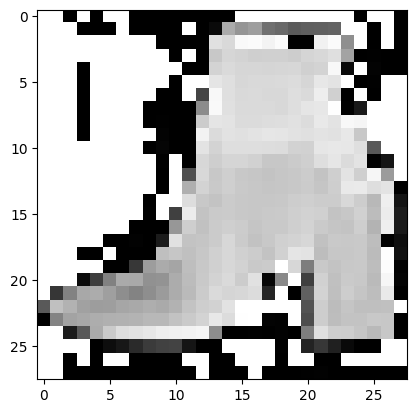

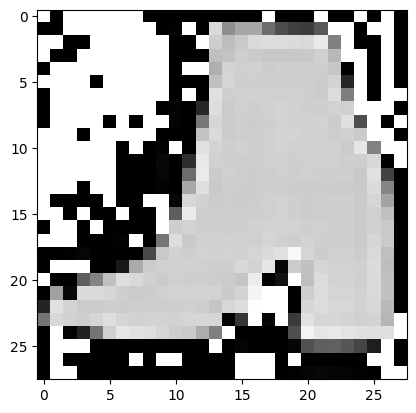

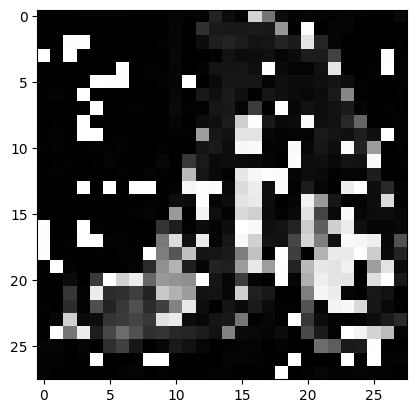

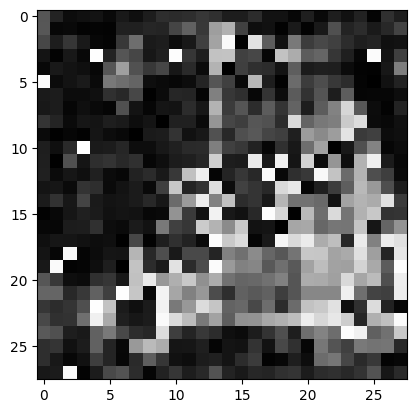

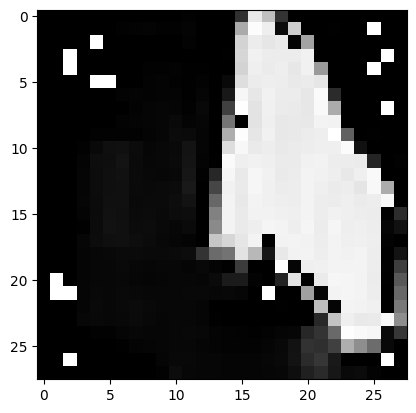

In [3]:
### Adversarial attacks via gradient descent on eps ###
y_0 = torch.tensor([0], device='cuda:0')
y_1 = torch.tensor([9], device='cuda:0')

deterministic=False
noises = fashion_mnist_cond_diffusion.explicit_sample(y_0, deterministic=deterministic)
adversarial_target = fashion_mnist_cond_diffusion.sample(y_1).squeeze(0)

os.makedirs('../outputs/adversary/descent/conditional', exist_ok=True)
plt.figure()
plt.imshow(reverse_transform(noises[-1].squeeze(0).cpu()), cmap='gray')
plt.savefig(f'../outputs/adversary/descent/conditional/original.png')

plt.figure()
plt.imshow(reverse_transform(adversarial_target.squeeze(0).cpu()), cmap='gray')
plt.savefig(f'../outputs/adversary/descent/conditional/adversarial_target.png')

t = 50
for t in range(50, 300, 50):
    for noise in noises:
        if noise.grad is not None:
            noise.grad.zero_()
    eps = 5
    latent_noise = noises[fashion_mnist_cond_diffusion.T - t]
    x_t = noises[-1]

    for ep in range(15):
        fashion_mnist_cond_diffusion.zero_grad()
        loss = torch.norm(x_t - adversarial_target)
        print('loss', loss.item())
        grad = torch.autograd.grad(loss, latent_noise, retain_graph=True)[0]
        latent_noise = latent_noise - eps * grad
        x_t = latent_noise
        for i in reversed(range(0, t)):
            t_cur = torch.tensor([i], device=device)
            x_t = fashion_mnist_cond_diffusion.sample_p_t_grad(x_t, t_cur, y_0, deterministic=deterministic)

    plt.figure()
    image = reverse_transform(x_t.squeeze(0).cpu())
    plt.imshow(image, cmap='gray')
    plt.savefig(f'../outputs/adversary/descent/conditional/perturbation_t_{t}.png')
    del x_t

In [ ]:
### Decoding from latent noise ###
os.makedirs('../outputs/latent_noise', exist_ok=True)
for t in range(0, 300, 50):
    y_0 = torch.tensor([0], device='cuda:0')

    noise = torch.randn(1, 1, 28, 28).to(device)
    x_t = noise
    for i in reversed(range(0, t)):
        t_cur = torch.tensor([i], device='cuda:0')
        x_t = fashion_mnist_cond_diffusion.sample_p_t(x_t, t_cur, y_0)

    image = reverse_transform(x_t.squeeze(0).cpu())
    plt.imshow(image, cmap='gray')
    plt.savefig(f'../outputs/latent_noise/decoded_latent_noise_t_{t}.png')

In [ ]:
### Adversarial attacks via latent space interpolation ###
os.makedirs('../outputs/adversary', exist_ok=True)
y_0 = torch.tensor([0], device='cuda:0')
y_1 = torch.tensor([1], device='cuda:0')
deterministic=False

noises = fashion_mnist_cond_diffusion.explicit_sample(y_0, deterministic=deterministic)
adversarial_target = fashion_mnist_cond_diffusion.sample(y_1).squeeze(0)